In [1]:
import os
from copy import deepcopy
import glob
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import torchvision.transforms as _T

from torch.utils.data import DataLoader
import librosa
from functools import partial
import sys
sys.path.append("../")
from dataloaders.rawaudiodataset import RawAudioDataset
from dataloaders.audiodataset  import AudioDataset

In [2]:
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  # power_spec = librosa.power_to_db(spec)
  power_spec = spec
  im = axs.imshow(power_spec, origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

def get_spectrogram(waveform,*args, **kwargs):
  spectrogram = T.Spectrogram(
      *args, **kwargs
  )
  mel_scale = MelScale(
            n_mels=256, sample_rate=22050, n_stft=1024// 2 + 1)

  return mel_scale(spectrogram(waveform))
  # return spectrogram(waveform)

In [3]:
def _custom_collate_2(batch_):  #Collate function for Raw Audio
    def contains_none(b):
        for elem in b:
            if elem is None:
                return False
        return True
    batch = list(filter(lambda x: contains_none(x), batch_))
    input = torch.stack([b[0] for b in batch])
    label = torch.stack([b[1] for b in batch])
    if len(batch[0]) == 2:
        return input, label
    filepath = [b[2] for b in batch]
    return input, label, filepath


def _custom_collate(batch_):
    def contains_none(b):
        for elem in b:
            if elem is None:
                return False
        return True
    # print(batch_)
    batch = list(filter(lambda x: contains_none(x), batch_))
    input = torch.stack([b[0] for b in batch])
    label = torch.stack([b[1] for b in batch])
    if len(batch[0]) == 2:
        return input, label
    filepath = [b[2] for b in batch]
    return input, label, filepath

/Users/test/Documents/Projects/Master/ArticBirdsSounds/audio_annots/cleaned_train/AMGP/2019_UTQI-2_20190616-100000_5_a3e914.wav


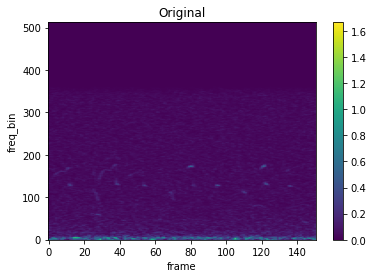

In [25]:
# sample_file = glob.glob("/Users/test/Documents/Projects/Master/birds-generation/data/cleaned_train/Erirub_song/*.wav")[0]
sample_file = glob.glob("/Users/test/Documents/Projects/Master/ArticBirdsSounds/audio_annots/cleaned_train/AMGP/*.wav")[5]
# audio_spec = np.load(sample_file)


audio_file =  os.path.splitext(sample_file)[0]+".wav"
print(audio_file)
assert os.path.isfile(audio_file), (audio_file, sample_file)
# audio, sr = torchaudio.load(audio_file)
audio, sr = AudioDataset._get_sample(path=audio_file, resample=22050)
spec = get_spectrogram(audio, n_fft=1024, win_length=1024, hop_length=256, center=True, pad_mode="reflect", power=1.0)
plot_spectrogram(spec[0], title="Original")

In [5]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1., p=0.5):
        self.std = std
        self.mean = mean
        self.p = p
        
    def __call__(self, tensor):
        if np.random.rand() > self.p:
            return tensor
        else:
            return tensor + torch.randn(tensor.size()) 
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

def custom_augment_torchaudio(input, transforms):
    image = deepcopy(input)
    ops = [
        ]
    for transform in transforms:
        transform = transform.lower()
        if "masking" in transform:
            max_mask_size = 7
            ops.append(T.FrequencyMasking(freq_mask_param=max_mask_size))
            ops.append(T.TimeMasking(time_mask_param=max_mask_size))
        elif transform == "input_dropout":
            ops.append(_T.RandomErasing(p=1.0, scale=(0.01, 0.1), inplace=False))
        elif transform == "spec_stretching":
            ops.append(T.TimeStretch(n_freq=128, fixed_rate=0.5))
    
    # ops.append( _T.Resize(size=(512, 64)))
    print(ops)
    out = {"image": _T.Compose(ops)(image)}
    return out



def custom_augment(input, transforms):

    image = deepcopy(input)
    
    if isinstance(transforms, _T.Compose):
        out = {"image": transforms(image)}
        return out

    for transform in transforms:
        transform = transform.lower()
        print("Before", image.shape)
        # remove a portion of 20 pixels at random position in the image along the frequency axis using numpy slicing

        max_mask_size = 7
        if transform == "freqmasking":
            mazk_size = np.random.randint(0, max_mask_size)
            start = np.random.randint(0, image.shape[1] -mazk_size )
            image[:, start:start +mazk_size , :] = 0 # Image shape is (1, 256, 32)
        elif transform == "timemasking":
            mazk_size = np.random.randint(0, max_mask_size)
            start = np.random.randint(0, image.shape[2] -mazk_size )
            image[:, :, start:start +mazk_size ] = 0
        elif transform == "masking":
            mazk_size = np.random.randint(0, max_mask_size)
            start = np.random.randint(0, image.shape[1] -mazk_size )
            image[:, start:start +mazk_size , :] = 0
            mazk_size = np.random.randint(0, max_mask_size)
            start = np.random.randint(0, image.shape[2] -mazk_size )
            image[:, :, start:start +mazk_size ] = 0
        else:
            raise NotImplementedError

            print("After", image.shape)
    out = {"image":image}
    return out 

Classes in the dataset:  ['Turphi_song', 'Alaarv_song', 'Galcri_call', 'Parate_song', 'Erirub_song', 'Cetcet_song', 'Serser_song', 'Sylcan_song', 'Turmer_call', 'Sylcan_call']
Overriding spec variables because use_spectrogram is true
Data initialization
All paths 177
Loaded data from cache 177 177
[FrequencyMasking(), TimeMasking(), TimeStretch(), RandomErasing(p=1.0, scale=(0.01, 0.1), ratio=(0.3, 3.3), value=0, inplace=False)]
[FrequencyMasking(), TimeMasking(), TimeStretch(), RandomErasing(p=1.0, scale=(0.01, 0.1), ratio=(0.3, 3.3), value=0, inplace=False)]
[FrequencyMasking(), TimeMasking(), TimeStretch(), RandomErasing(p=1.0, scale=(0.01, 0.1), ratio=(0.3, 3.3), value=0, inplace=False)]
tensor(0.) tensor(1.4660)


/Users/test/miniconda3/envs/scologan/lib/python3.7/site-packages/torchvision/transforms/functional_tensor.py:530: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Copy.cpp:250.)
  img = img.to(req_dtype)


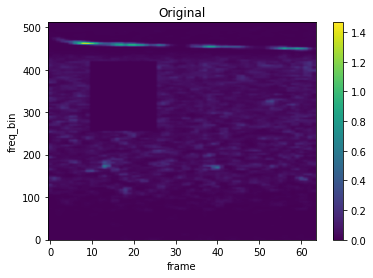

tensor(0.) tensor(3.5790)


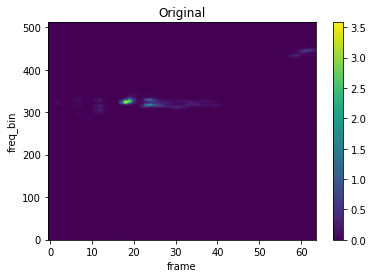

tensor(0.) tensor(0.0365)


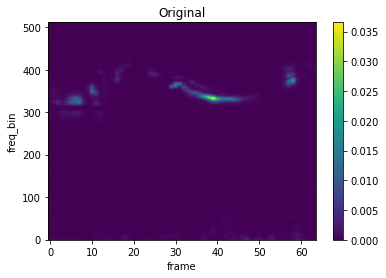

[FrequencyMasking(), TimeMasking(), TimeStretch(), RandomErasing(p=1.0, scale=(0.01, 0.1), ratio=(0.3, 3.3), value=0, inplace=False)]
[FrequencyMasking(), TimeMasking(), TimeStretch(), RandomErasing(p=1.0, scale=(0.01, 0.1), ratio=(0.3, 3.3), value=0, inplace=False)]
[FrequencyMasking(), TimeMasking(), TimeStretch(), RandomErasing(p=1.0, scale=(0.01, 0.1), ratio=(0.3, 3.3), value=0, inplace=False)]
tensor(0.) tensor(0.9970)


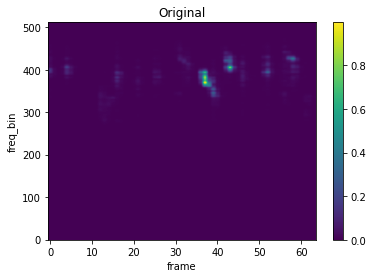

tensor(0.) tensor(0.0113)


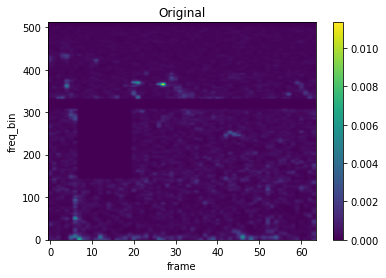

tensor(0.) tensor(0.0757)


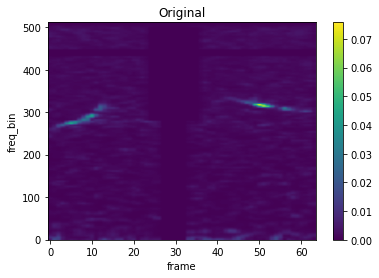

[FrequencyMasking(), TimeMasking(), TimeStretch(), RandomErasing(p=1.0, scale=(0.01, 0.1), ratio=(0.3, 3.3), value=0, inplace=False)]
[FrequencyMasking(), TimeMasking(), TimeStretch(), RandomErasing(p=1.0, scale=(0.01, 0.1), ratio=(0.3, 3.3), value=0, inplace=False)]
[FrequencyMasking(), TimeMasking(), TimeStretch(), RandomErasing(p=1.0, scale=(0.01, 0.1), ratio=(0.3, 3.3), value=0, inplace=False)]
tensor(0.) tensor(0.0320)


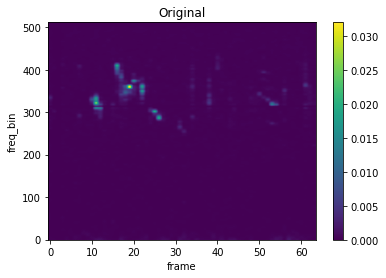

tensor(0.) tensor(0.0194)


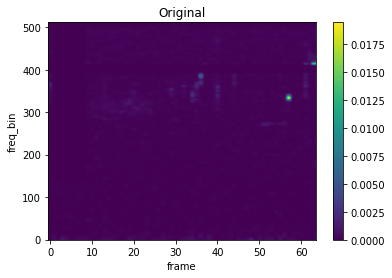

tensor(0.) tensor(0.0972)


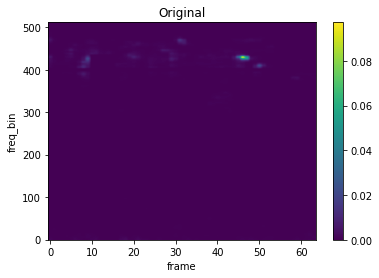

[FrequencyMasking(), TimeMasking(), TimeStretch(), RandomErasing(p=1.0, scale=(0.01, 0.1), ratio=(0.3, 3.3), value=0, inplace=False)]
[FrequencyMasking(), TimeMasking(), TimeStretch(), RandomErasing(p=1.0, scale=(0.01, 0.1), ratio=(0.3, 3.3), value=0, inplace=False)]
[FrequencyMasking(), TimeMasking(), TimeStretch(), RandomErasing(p=1.0, scale=(0.01, 0.1), ratio=(0.3, 3.3), value=0, inplace=False)]
tensor(0.) tensor(1.4702)


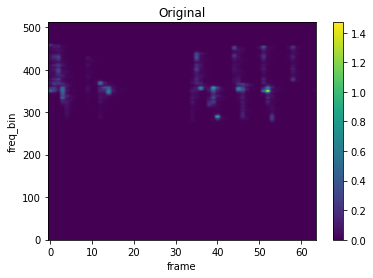

tensor(0.) tensor(0.1182)


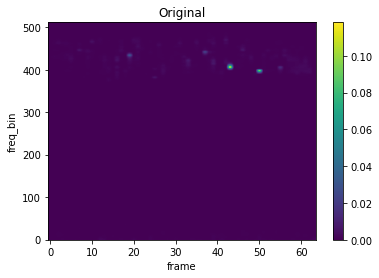

tensor(0.) tensor(2.4978)


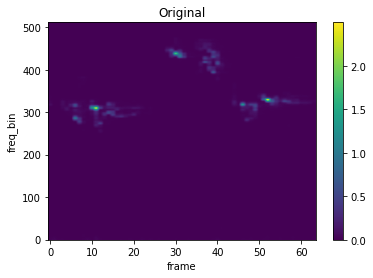

[FrequencyMasking(), TimeMasking(), TimeStretch(), RandomErasing(p=1.0, scale=(0.01, 0.1), ratio=(0.3, 3.3), value=0, inplace=False)]
[FrequencyMasking(), TimeMasking(), TimeStretch(), RandomErasing(p=1.0, scale=(0.01, 0.1), ratio=(0.3, 3.3), value=0, inplace=False)]
[FrequencyMasking(), TimeMasking(), TimeStretch(), RandomErasing(p=1.0, scale=(0.01, 0.1), ratio=(0.3, 3.3), value=0, inplace=False)]
tensor(0.) tensor(0.1699)


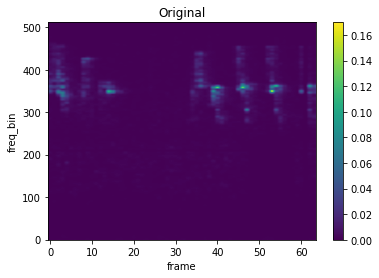

tensor(0.) tensor(0.1397)


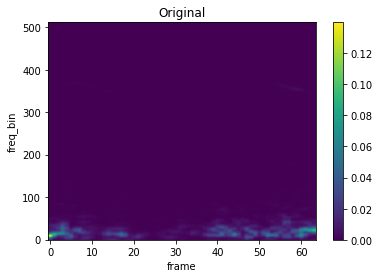

tensor(0.) tensor(0.0148)


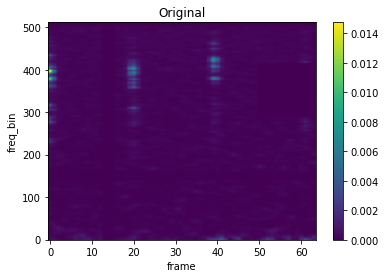

[FrequencyMasking(), TimeMasking(), TimeStretch(), RandomErasing(p=1.0, scale=(0.01, 0.1), ratio=(0.3, 3.3), value=0, inplace=False)]
[FrequencyMasking(), TimeMasking(), TimeStretch(), RandomErasing(p=1.0, scale=(0.01, 0.1), ratio=(0.3, 3.3), value=0, inplace=False)]
[FrequencyMasking(), TimeMasking(), TimeStretch(), RandomErasing(p=1.0, scale=(0.01, 0.1), ratio=(0.3, 3.3), value=0, inplace=False)]
tensor(0.) tensor(3.8150)


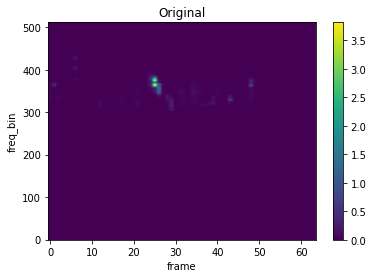

tensor(0.) tensor(3.9964)


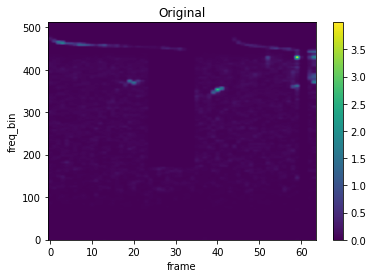

tensor(0.) tensor(0.0852)


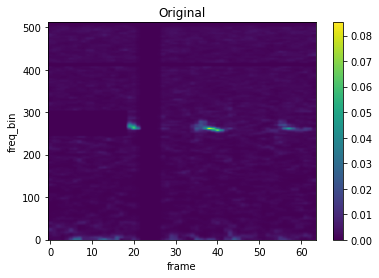

[FrequencyMasking(), TimeMasking(), TimeStretch(), RandomErasing(p=1.0, scale=(0.01, 0.1), ratio=(0.3, 3.3), value=0, inplace=False)]
[FrequencyMasking(), TimeMasking(), TimeStretch(), RandomErasing(p=1.0, scale=(0.01, 0.1), ratio=(0.3, 3.3), value=0, inplace=False)]
[FrequencyMasking(), TimeMasking(), TimeStretch(), RandomErasing(p=1.0, scale=(0.01, 0.1), ratio=(0.3, 3.3), value=0, inplace=False)]
tensor(0.) tensor(0.0055)


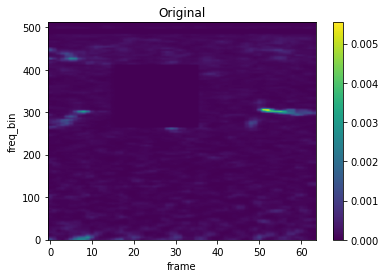

tensor(0.) tensor(0.5370)


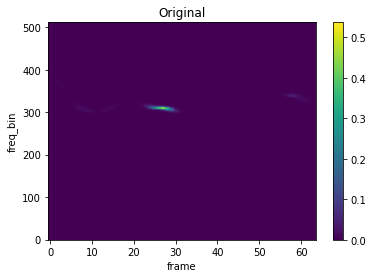

tensor(0.) tensor(4.6676)


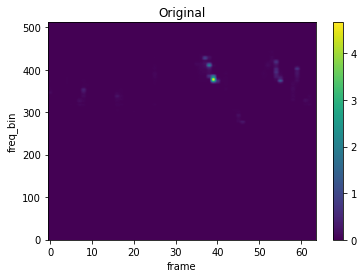

In [6]:
#Instantiate an object of the class rawaudiodataset
classes = os.listdir("../../data/cleaned_train") 
#remove .DS_Store from the list of classes
classes = [x for x in classes if x != ".DS_Store"]
print("Classes in the dataset: ", classes)

# transform = T.FrequencyMasking(freq_mask_param=80)
# transforms = _T.Compose(
#     [
#         _T.Resize(size=(512, 64)),
#         T.FrequencyMasking(freq_mask_param=10),
#         T.TimeMasking(time_mask_param=10),
#         # T.TimeStretch(n_freq=512, fixed_rate=0.5),
#     ]
# )

transforms = ["masking","spec_stretching", "input_dropout", "input_noise"]
transform = partial(custom_augment_torchaudio, transforms=transforms)
#Create a dataset object
batch_size = 3
# dataset = RawAudioDataset(data_path="../../data/cleaned_train.txt", root_dir="../../data/", classes_name=classes, sr=16000, window_length=16384, use_spectrogram=True, transform=transform)
dataset = AudioDataset(data_path="../../data/cleaned_train.txt", root_dir="../../data/", classes_name=classes, sr=22050, window_length=16384, use_spectrogram=True, transforms=transform, return_tuple=True, return_tuple_of3=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=_custom_collate)

for i, sample in enumerate(dataloader):
  spec = sample[0]
  for j in range(batch_size):
    spec_temp = spec.squeeze(1)[j]
    print(spec_temp.min(), spec_temp.max())
    plot_spectrogram(spec_temp, title="Original")
  if i > 5:
    break
# del dataset

In [7]:
# def _get_sample(path, resample=None):
#     effects = [["remix", "1"]]
#     if resample:
#         effects.extend(
#             [
#                 ["lowpass", f"{resample // 2}"],
#                 ["rate", f"{resample}"],
#             ]
#         )
#     return torchaudio.sox_effects.apply_effects_file(path, effects=effects)


# def get_speech_sample(audio_path, resample=None):
#     return _get_sample(audio_path, resample=resample)
# def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
#     fig, axs = plt.subplots(1, 1)
#     axs.set_title(title or "Spectrogram (db)")
#     axs.set_ylabel(ylabel)
#     axs.set_xlabel("frame")
#     im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect=aspect)
#     if xmax:
#         axs.set_xlim((0, xmax))
#     fig.colorbar(im, ax=axs)
#     plt.show(block=False)


In [8]:
# audio_file = "../../data/cleaned_train/Sylcan_song/nips4b_birds_trainfile034-42e299.wav"
# waveform, sr = get_speech_sample(audio_file, resample=16384)
# spectrogram = T.Spectrogram(
#     n_fft=1024,
#     win_length=1024,
#     hop_length=256,
#     center=True,
#     pad_mode="reflect",
#     power=2.0,
# )
# spec = spectrogram(waveform)
# print(spec.shape)
# plot_spectrogram(spec[0])

In [9]:
# for i, file in enumerate(glob.glob("/Users/test/Documents/Projects/Master/ArticBirdsSounds/audio_annots/augmented/specaug/Gull/*.npy")):
#     audio = np.load(file)
#     print(audio.shape)
#     plt.imshow(audio)
#     plt.show()
#     if i > 10:
#         break